In [1]:
# general libraries
import numpy as np
import pandas as pd
import time
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [2]:
from keras.datasets import mnist
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

In [3]:
mnist_x_train = mnist_x_train.astype('float32') / 255.
mnist_x_test = mnist_x_test.astype('float32') / 255.
mnist_x_train = mnist_x_train.reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
mnist_x_test = mnist_x_test.reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))

In [4]:
from keras.datasets import fashion_mnist
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = fashion_mnist.load_data()

In [5]:
fashion_x_train = fashion_x_train.astype('float32') / 255.
fashion_x_test = fashion_x_test.astype('float32') / 255.
fashion_x_train = fashion_x_train.reshape((len(fashion_x_train), np.prod(fashion_x_train.shape[1:])))
fashion_x_test = fashion_x_test.reshape((len(fashion_x_test), np.prod(fashion_x_test.shape[1:])))

Now let’s explain better what anomaly detection means. Let’s create a special dataset that is made of the 10000 images of the MNIST test dataset and one single image from the fashion MNIST dataset. Our goal in this notebook will be to find this image automatically without looking at them. Can we do it?

In [6]:
x_test = mnist_x_test
for i in range(2):
    x_test = np.concatenate((x_test, fashion_x_test[i].reshape(1,784)))
print(x_test.shape)

(10002, 784)


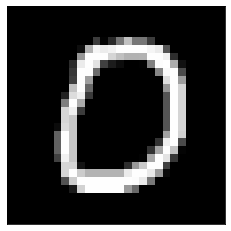

In [7]:
plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False) 
plt.tick_params(axis = 'y', which = 'both', left = False, right = False, labelleft = False)

plt.imshow(mnist_x_test[10].reshape(28, 28))

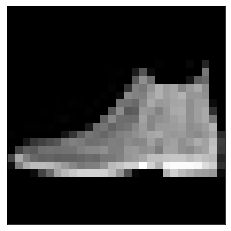

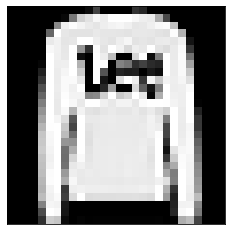

In [8]:
for i in range(2):
    plt.gray()
    plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, 
                    labelbottom = False) 
    plt.tick_params(axis = 'y', which = 'both', left = False, right = False, 
                    labelleft = False)

    plt.imshow(fashion_x_test[i].reshape(28, 28))
    plt.show()

In [9]:
def create_autoencoders(feature_layer_dim = 16):
    input_img = Input(shape = (784,), name = 'Input_Layer')
    # 784 is the total number of pixels of MNIST images

    # The layer encoded has a dimension equal to feature_layer_dim and contains
    # the encoded input (therefore the name)
    encoded = Dense(feature_layer_dim, activation = 'relu', name = 'Encoded_Features')(input_img)
    decoded = Dense(784, activation = 'sigmoid', name = 'Decoded_Input')(encoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    encoded_input = Input(shape = (feature_layer_dim,))
    decoder = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder(encoded_input))

    return autoencoder, encoder, decoder

In [10]:
autoencoder, encoder, decoder = create_autoencoders(64)

autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

history = autoencoder.fit(mnist_x_train, mnist_x_train, epochs = 30,
                          batch_size = 256, shuffle = True,
                          validation_data = (mnist_x_test, mnist_x_test),
                          verbose = 0)

In [11]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [12]:
RE = ((x_test - decoded_imgs)**2).mean(axis = 1)
RE_original = RE.copy()

In [13]:
RE.sort()
print(RE[9990:])

[0.01793028 0.01799711 0.01810498 0.01813813 0.01872291 0.01892933
 0.01895804 0.0189717  0.01910594 0.02166471 0.05987502 0.29712778]


We can see that the third highest reconstruction error (0.02529096) is less than half (and 10 times small) of the RE for the added image (0.05736294 and 0.29712778). Below we can see the original image and the one that the trained autoencoder has reconstructed. We can see how the reconstructed image does not look like the original at all.

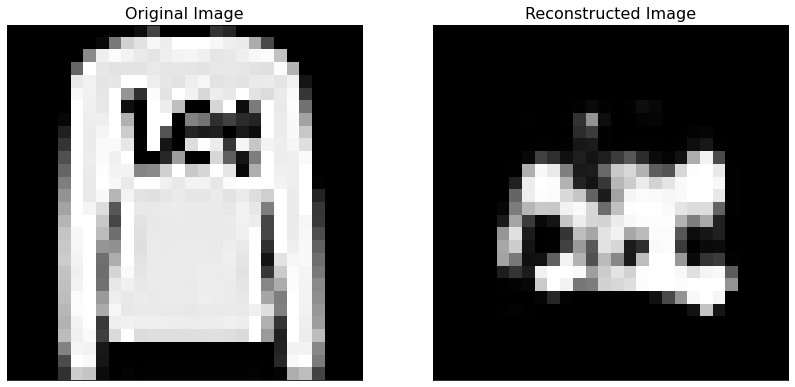

In [14]:
biggest_re_pos = np.argmax(RE_original)

fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.title('Original Image', fontsize = 16)

plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, 
                labelbottom = False) 
plt.tick_params(axis = 'y', which = 'both', left = False, right = False, 
                labelleft = False)

plt.imshow(x_test[biggest_re_pos].reshape(28, 28))

ax = fig.add_subplot(1, 2, 2)
plt.title('Reconstructed Image', fontsize = 16)
plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, 
                labelbottom = False) 
plt.tick_params(axis = 'y', which = 'both', left = False, right = False, 
                labelleft = False)

plt.imshow(decoded_imgs[biggest_re_pos].reshape(28, 28))

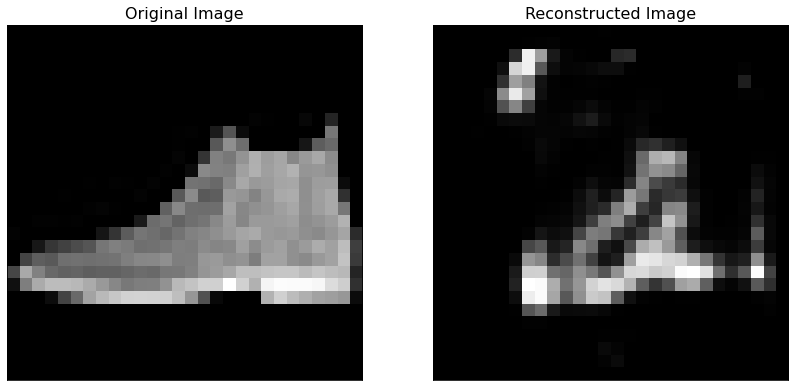

In [15]:
second_biggest_re_pos = list(RE_original).index(RE[-2])
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, 
                labelbottom = False) 
plt.tick_params(axis = 'y', which = 'both', left = False, right = False, 
                labelleft = False)
plt.title('Original Image', fontsize = 16)
plt.gray()
plt.imshow(x_test[second_biggest_re_pos].reshape(28, 28))

ax = fig.add_subplot(1, 2, 2)
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, 
                labelbottom = False) 
plt.tick_params(axis = 'y', which = 'both', left = False, right = False, 
                labelleft = False)
plt.title('Reconstructed Image', fontsize = 16)
plt.gray()
plt.imshow(decoded_imgs[second_biggest_re_pos].reshape(28, 28))

Third biggest RE

The image shown below (and its reconstructed version) is the one with the third highest reconstruction error. The reason is clear, this image does not seems like a hand-written digit at all! That could even count as an outlier in the dataset.

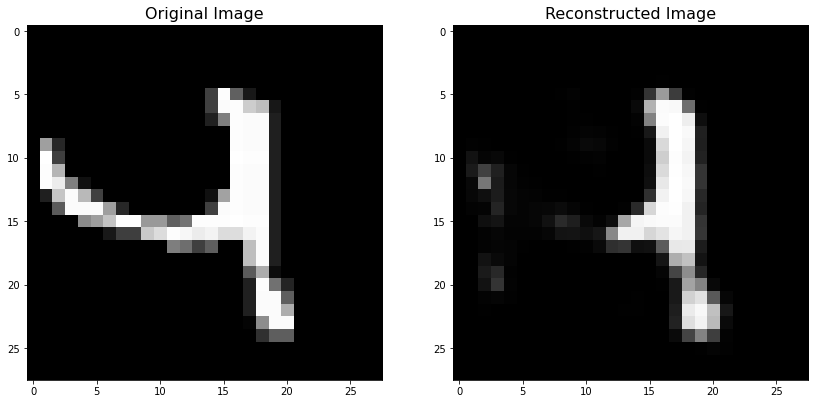

In [16]:
third_biggest_re_pos = list(RE_original).index(RE[-3])
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.title('Original Image', fontsize = 16)
plt.gray()
plt.imshow(x_test[third_biggest_re_pos].reshape(28,28))

ax = fig.add_subplot(1, 2, 2)
plt.title('Reconstructed Image', fontsize = 16)
plt.gray()
plt.imshow(decoded_imgs[third_biggest_re_pos].reshape(28,28))

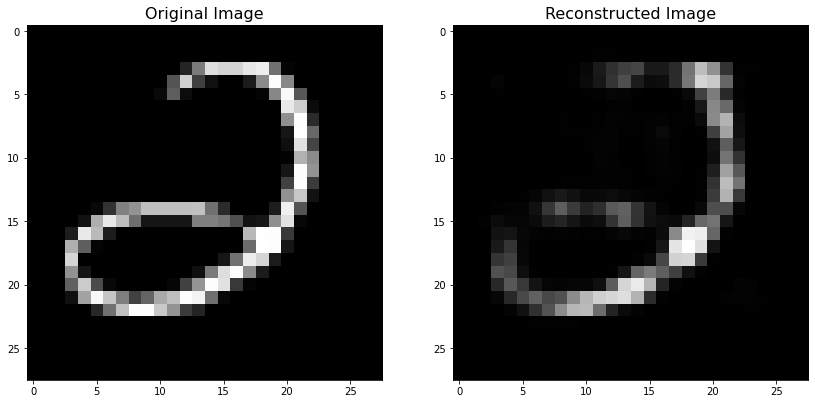

In [17]:
forth_biggest_re_pos = list(RE_original).index(RE[-4])
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.title('Original Image', fontsize = 16)
plt.gray()
plt.imshow(x_test[forth_biggest_re_pos].reshape(28,28))

ax = fig.add_subplot(1, 2, 2)
plt.title('Reconstructed Image', fontsize = 16)
plt.gray()
plt.imshow(decoded_imgs[forth_biggest_re_pos].reshape(28,28))